###Building a Classifier for Mutagenicity Prediction. 

### Introduction

A chemical compound can not be considered as a drug candidate if it doesn't pass the mutagenicity test. Mutagenicity is a property of a compound to cause mutations and pose a toxic risk to humans. That's why it is very important to detect the toxicity of a drug candidate at early stages. In this tutorial we will implement different approaches in order to build a flexible classifier for mutagenicity prediction.

At the time I was writing this tutorial, I didn't know about the existence of a larger data set (7090 compounds), so I am going to use my initial data set (4336 compounds) from this [source](http://cheminformatics.org/datasets/bursi/).

The tutorial consist of four parts. In part one, we will make a classifier using  descriptors. In part two, the classifier will be based on the knowledge about toxicophores. In part three, we will implement a voting system to  and in the final part I will test the performance of the classifiers on a bigger dataset.|


### Part I. Building  a machine learning classifier based on descriptors.

We will use [RDKIT](http://www.rdkit.org/) to extract the molecule descriptors (features).

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

def extract_features(file_name):
    '''
    Return a list of descriptors and class labels
    '''
    list_of_descr = []
    sdf =  [i for i in Chem.SDMolSupplier(file_name) if i is not None]
    classes={'nonmutagen':0,'mutagen':1}
    for mol in sdf:    
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(descr_names)
        each_mol = [i for i in calc.CalcDescriptors(mol)]
        smiles = Chem.MolToSmiles(mol)
        bin_label = classes[mol.GetProp('Ames test categorisation')]        
        each_mol.append(smiles)
        each_mol.append(bin_label) 
        list_of_descr.append(each_mol)
    
    return list_of_descr

descr_names = [i[0] for i in Descriptors._descList if i[0] != 'ExactMolWt']

data = extract_features('cas_4337.sdf')

# Appending 'labels' to the descriptors names
descr_names.append('smiles')
descr_names.append('labels')


In [ ]:
import csv

# Writing data to .csv files
def write_to_csv(file_name, data):
    with open(file_name, 'wb') as f:
        csv_writer = csv.writer(f, delimiter = ',')
        csv_writer.writerow(descr_names)
        csv_writer.writerows(data)
        
write_to_csv('rdkit_mutagens.csv', data)

Splitting the data into a training and a testing sets.

In [ ]:
import random


def split_data(input_file, n):
    '''
    Split data into a training and a testing sets. n - is a size of a training set.
    '''
    with open(input_file, 'rb') as f:
        csv_reader = csv.reader(f, delimiter = ',')
        header = csv_reader.next()
        data = [row for row in csv_reader]
        train_data = random.sample(data, n)
        test_data = [i for i in data if i not in train_data]
    return header, train_data, test_data

header, train_data, test_data = split_data('rdkit_mutagens.csv', 3000)    

In [ ]:
def write_to_csv(file_name, header, data):
    """
    Write data to a .csv file
    """
    with open(file_name, 'wb') as f:
        csv_writer = csv.writer(f, delimiter=',')
        csv_writer.writerow(header)
        csv_writer.writerows(data)
        
write_to_csv('rdkit_mutagens_train.csv', header, train_data)
write_to_csv('rdkit_mutagens_test.csv', header, test_data)

Downloads: [rdkit_mutagens_train.csv](https://www.dropbox.com/s/kjda2l2hi19unp8/rdkit_mutagens_train.csv?dl=0), [rdkit_mutagens_test.csv](https://www.dropbox.com/s/z0llcq3s66ygbx4/rdkit_mutagens_test.csv?dl=0)

### Building the classifier.

In [1]:
import pandas as pd

In [2]:
# Loading data into Pandas
df_train = pd.read_csv('rdkit_mutagens_train.csv').dropna()
df_test = pd.read_csv('rdkit_mutagens_test.csv').dropna()

# X -> features, y -> labels
X_train = df_train[df_train.columns[:-2]]
y_train = df_train['labels']

X_test = df_test[df_test.columns[:-2]]
y_test = df_test['labels']

#### *It is very important to standardize the features otherwise the classifier will perform very badly!*

In [3]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler().fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

#### There are several machine learning algorithms for classification and we are going to start with the Naive Bayes.

In [4]:
from sklearn.naive_bayes import GaussianNB 
from sklearn import metrics

nb = GaussianNB()

# Training the model
nb.fit(X_train_std, y_train)

# Predicting labels
nb_pred = nb.predict(X_test_std)

# Measuring accuracy of the model
accuracy = metrics.accuracy_score(y_test, nb_pred)

print "Accuracy is: {}".format(round(accuracy, 4))

#Confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, nb_pred)
print '\n',conf_matrix

Accuracy is: 0.6362

[[181 433]
 [ 53 669]]


In [5]:
from __future__ import division

# Sensitivity = (TP)/(TP + FN)
# Specificity = (TN)/(TN + FP)

def spec_sens(matrix):
    print "Specificity:", matrix[1,1]/sum(matrix[1, :])
    print "Sensitivity:", matrix[0,0]/sum(matrix[0,:])
    
spec_sens(conf_matrix)

Specificity: 0.926592797784
Sensitivity: 0.294788273616


In [6]:
# another way to get a classification report
print metrics.classification_report(y_test, nb_pred)

             precision    recall  f1-score   support

          0       0.77      0.29      0.43       614
          1       0.61      0.93      0.73       722

avg / total       0.68      0.64      0.59      1336



In [7]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

Plotting the results.

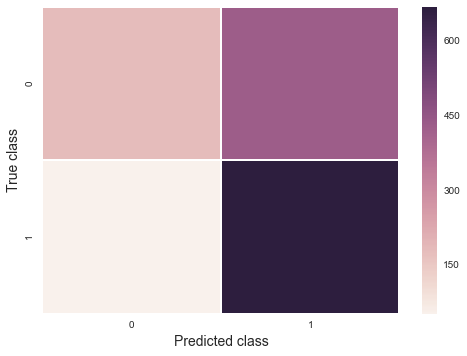

In [8]:
sns.heatmap(metrics.confusion_matrix(y_test, nb_pred))
plt.xlabel('Predicted class', fontsize = 14)
plt.ylabel('True class', fontsize = 14)
plt.show()

#### Next algorithm to try is Logistic Regression.

In [9]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

# Training the model
log_reg.fit(X_train_std, y_train)

# Predicting labels
log_pred = log_reg.predict(X_test_std)

# Measuring accuracy of the model
accuracy = metrics.accuracy_score(y_test, log_pred)

print "Accuracy is: {}".format(round(accuracy, 4))

#Confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, log_pred)
print '\n',conf_matrix

Accuracy is: 0.7934

[[473 141]
 [135 587]]


In [10]:
# Sensitivity = (TP)/(TP + FN)
# Specificity = (TN)/(TN + FP)

def spec_sens(matrix):
    print "Specificity:", float(matrix[1,1])/sum(matrix[1, :])
    print "Sensitivity:", float(matrix[0,0])/sum(matrix[0,:])
    
spec_sens(conf_matrix)

Specificity: 0.813019390582
Sensitivity: 0.770358306189


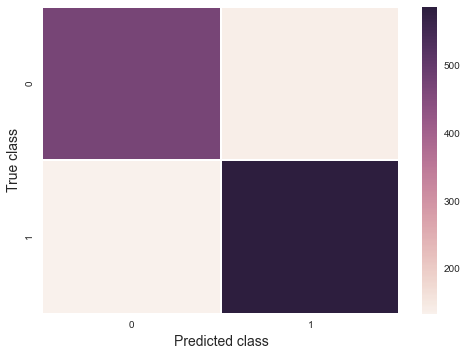

In [11]:
sns.heatmap(metrics.confusion_matrix(y_test, log_pred))
plt.xlabel('Predicted class', fontsize = 14)
plt.ylabel('True class', fontsize = 14)
plt.show()

#### Next classifier is KNeighborsClassifier.

In [12]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)

# Training the model
knn.fit(X_train_std, y_train)

# Predicting labels
knn_pred = knn.predict(X_test_std)

# Measuring accuracy of the model
accuracy = metrics.accuracy_score(y_test, knn_pred)

print "Accuracy is: {}".format(round(accuracy, 4))

#Confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, knn_pred)
print '\n',conf_matrix

Accuracy is: 0.8091

[[469 145]
 [110 612]]


In [13]:
def spec_sens(matrix):
    print "Specificity:", float(matrix[1,1])/sum(matrix[1, :])
    print "Sensitivity:", float(matrix[0,0])/sum(matrix[0,:])
    
spec_sens(conf_matrix)

Specificity: 0.847645429363
Sensitivity: 0.763843648208


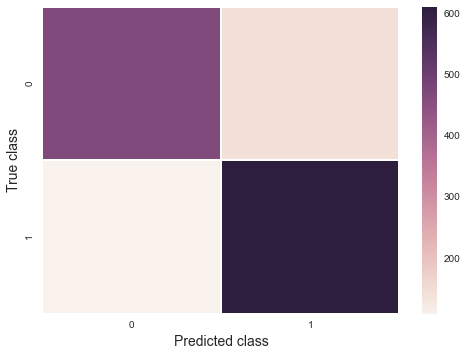

In [14]:
sns.heatmap(metrics.confusion_matrix(y_test, knn_pred))
plt.xlabel('Predicted class', fontsize = 14)
plt.ylabel('True class', fontsize = 14)
plt.show()

#### The  Random Forest Classifier.

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100)

# Training the model
rf.fit(X_train_std, y_train)

# Predicting labels
rf_pred = rf.predict(X_test_std)

# Measuring accuracy of the model
rf_accuracy = metrics.accuracy_score(y_test, rf_pred)

print "Accuracy is: {}".format(round(rf_accuracy, 4))

#Confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, rf_pred)
print '\n',conf_matrix, '\n'
def spec_sens(matrix):
    print "Specificity:", float(matrix[1,1])/sum(matrix[1, :])
    print "Sensitivity:", float(matrix[0,0])/sum(matrix[0,:])
    
spec_sens(conf_matrix)

Accuracy is: 0.8436

[[507 107]
 [102 620]] 

Specificity: 0.858725761773
Sensitivity: 0.825732899023


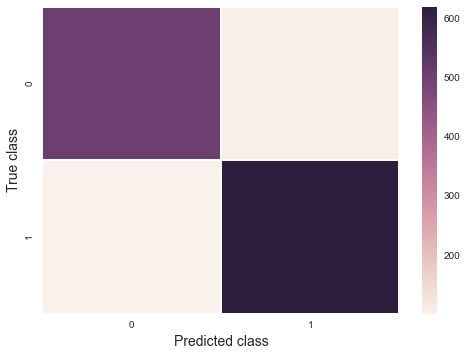

In [16]:
sns.heatmap(metrics.confusion_matrix(y_test, rf_pred))
plt.xlabel('Predicted class', fontsize = 14)
plt.ylabel('True class', fontsize = 14)
plt.show()

So, let's summarize the results in a table:

|   Classifier       | Acccuracy| Specificity| Sensitivity|
|--------------------|----------|------------|------------|
|Naive Bayes         |  0.64    |   0.93     |   0.29     |
|Logistic Regression |  0.79    |   0.81     |   0.77     | 
|KNeighbors          |  0.81    |   0.85     |   0.76     |
|Random Forest       |  0.84    |   0.86     |   0.83     |


In [17]:
# saving the Random Forest Classifier
import pickle

with open('mutagen_model.pickle', 'wb') as f:
  pickle.dump(rf, f)

As you can see, the Naive Bayes performed the worse and the performance of other algorithms is close to each other but the Random Forest gave the best results so we are going to use it in the further parts. In the second part, I will build a classifier using knowledge about toxicophores.